<link rel="stylesheet" href="https://cdn.jupyter.org/notebook/5.1.0/style/style.min.css">

# Benchmark analytical solution for fluid-like sphere
This notebook provides a benchmark test (comparing results and timing) for the analytical solution of a fluid-like sphere based on Anderson (1950) as implemented in *scatmod*, using methods defined in Python and R.

As benchmark, here we use one simulation at 200 kHz and a sweep of frequencies from 1 to 300 kHz at a 0.1 kHz interval. As a target we use a 1 cm sphere with a *g* and *h* of 1.0025, assuming the density of the surrounding water to be 1026 kg/$m^3$ measured at a distance of 10 m and only backscatter (e.g. scatter at 90 degrees is considered). 


In [294]:
#define the variables
c_w = 1500 
freqs = np.arange(.1,300,0.1)*1000
f = 200 * 1000
c_b = 1.0025*1500
Range = 10
Radius = 0.01
Rho_w = 1026
Rho_b = 1.0025 * Rho_w
Theta = 1.571
g = 1.0025
h = 1.0025



## Python  
Two different methods have been implemented in Python and are evaluated.

TS Anderson (1950) - Evaluating the TS took 2.12 seconds for 2999 simulations
TS Jech et al.(2015) - Evaluating the TS took 2.13 seconds for 2999 simulations


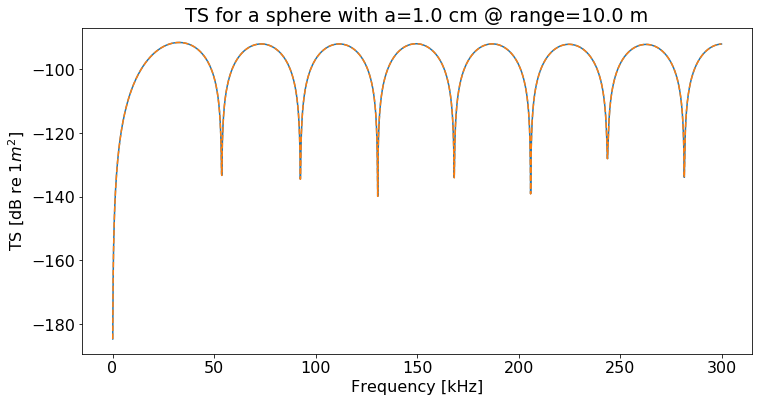

In [295]:
%matplotlib inline
#load packages
import numpy as np
from fluid_sphere import *
import time

#set plotting parameters
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

#Run the TS simulations

#single frequency
start = time.perf_counter()
TS_py = fluid_sphere(f=f,Radius=Radius, Range=Range,Rho_w=Rho_w,Rho_b=Rho_b,Theta=Theta,c_w=c_w,c_b=c_b)
end = time.perf_counter()
tel_s0 = end - start

#frequency range
start = time.perf_counter()
TS_py = [fluid_sphere(f=x,Radius=Radius, Range=Range,Rho_w=Rho_w,Rho_b=Rho_b,Theta=Theta,c_w=c_w,c_b=c_b) for x in freqs]
end = time.perf_counter()
tel_0 = end - start
print("TS Anderson (1950) - Evaluating the TS took %.2f seconds for %i simulations"%(tel_1, len(TS_py)))

#Run the TS simulations for the simplified model

#single frequency
start = time.perf_counter()
TS_py_sim = fluid_sphere_simple(f=f,r=Range,a=Radius,c=c_w,h=h,g=g,rho=Rho_w)
end = time.perf_counter()
tel_s1 = end - start

#frequency range
start = time.perf_counter()
TS_py_sim = [fluid_sphere_simple(f=x,r=Range,a=Radius,c=c_w,h=h,g=g,rho=Rho_w) for x in freqs]
end = time.perf_counter()
tel_1 = end - start
print("TS Jech et al.(2015) - Evaluating the TS took %.2f seconds for %i simulations"%(tel_1, len(TS_py_sim)))

#generate plot with matplotlib
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(freqs/1000, TS_py)
ax.plot(freqs/1000, TS_py_sim, "--")
plt.xlabel("Frequency [kHz]")
plt.ylabel("TS [dB re 1$m^2$]")
plt.title("TS for a sphere with a=%.1f cm @ range=%.1f m"%(Radius*100,Range))
plt.show()

## R
R functions for the analytical solution are identical to the *TS.sphere2* function included in *ZooScatR*.

[1] "Evaluating the TS took 3.1 seconds for 2999 simulations"


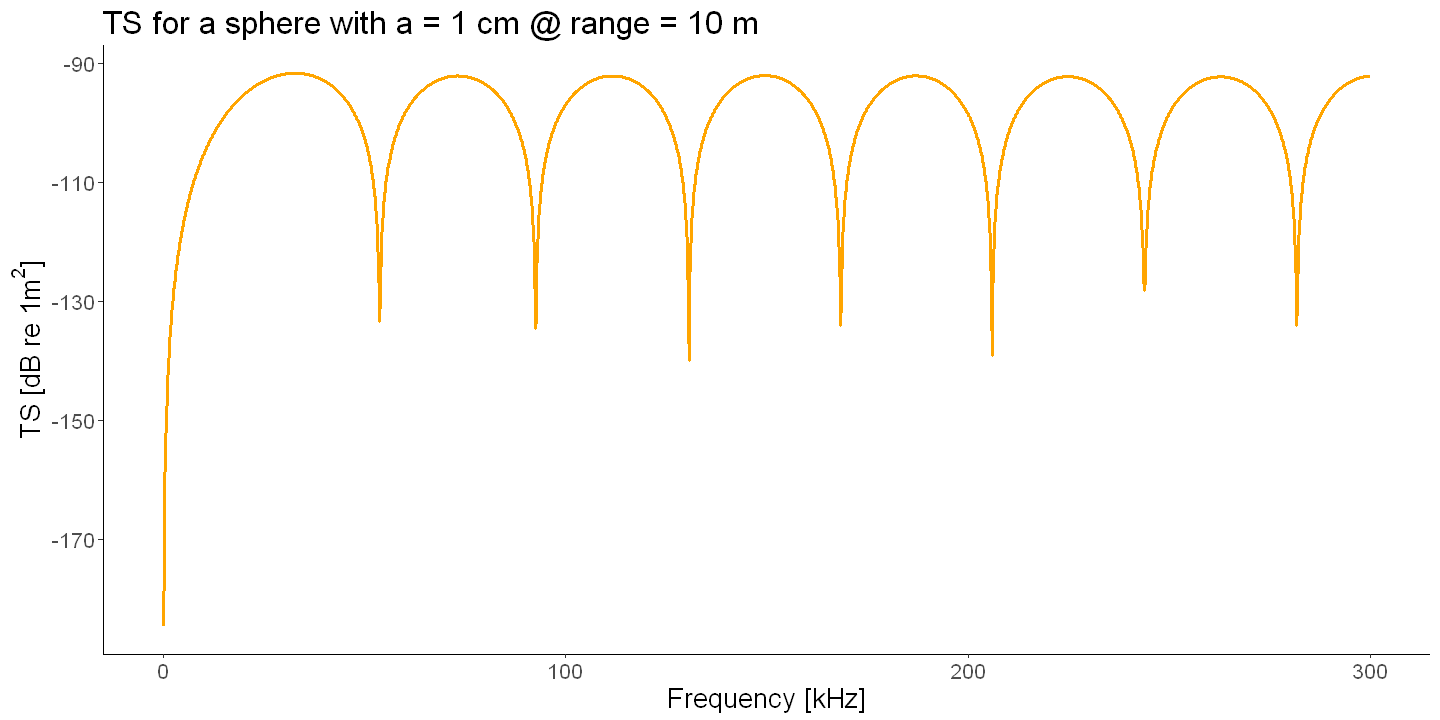

In [296]:
%get freqs Range Radius c_w h g Rho_w f

#load libraries
library(scatmod)
library(ggplot2)

#set plot size options
library(repr)
options(repr.plot.width=12, repr.plot.height=6)

#run the TS simulation

#single frequency
start_time <- Sys.time()
TS_R <- TS.sphere(f=f, r=Range,a=Radius,c=c_w,h=h,g=g,rho=Rho_w)
end_time <- Sys.time()
tel_sR <- end_time - start_time

#frequency range
start_time <- Sys.time()
TS_R <- as.numeric(sapply(freqs,TS.sphere2,r=Range,a=Radius,c=c_w,h=h,g=g,rho=Rho_w))
end_time <- Sys.time()
tel_R <- end_time - start_time

print(paste("Evaluating the TS took", round(tel_R,2), "seconds for",length(TS_R),"simulations"))

#create data frame with numeric values for easy plotting in ggplot
tsdat <- data.frame(cbind(freq=freqs,TS=TS_R))
tsdat$freq =  as.numeric(tsdat$freq)
tsdat$TS =  as.numeric(tsdat$TS)

#plot results with ggplot
ggplot(data=tsdat,aes(x=freq/1000,y=TS))+
    geom_path(lwd=1,col="orange")+
    xlab("Frequency [kHz]")+
    ylab( expression(paste("TS [dB re 1", m^{2},"]")))+
    ggtitle(paste("TS for a sphere with a =", round(a*100,2), "cm @ range =", round(r,1),"m"))+
    theme_classic()+
    theme(text = element_text(size=16))

## Comparing the outputs

### Estimation differences

In [297]:
%get TS_R tel_R tel_sR --from R

import pandas as pd

# Transform freqs into kHz
freqs=freqs/1000

#create data frame
d = {'freqs':freqs,'Python': TS_py,'Python Simp': TS_py_sim,'R':TS_R}
TSdf = pd.DataFrame(d)
TSdf['Py - Py Sim'] = np.abs(TSdf['Python Simp'] - TSdf['Python'])
TSdf['R - Py'] = np.abs(TSdf['Python'] - TSdf['R'])
TSdf['R - Py Sim'] = np.abs(TSdf['Python Simp'] - TSdf['R'])

print('Mean dB differences between the models:')
round(TSdf.mean(axis=0)[4:],3)

Mean dB differences between the models:


Py - Py Sim    0.002
R - Py         0.002
R - Py Sim     0.000
dtype: float64

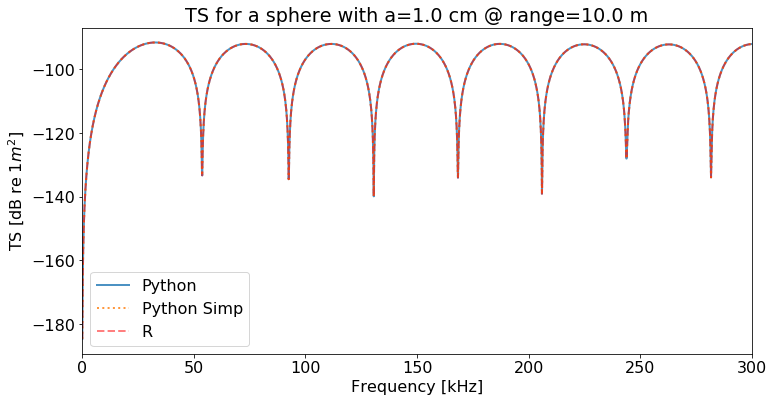

In [298]:
#Create TS comparison plot
fig, ax = plt.subplots(figsize=(12,6))

TSdf.plot(kind='line',x='freqs',y='Python',ax=ax,alpha=0.8,linewidth=2)
TSdf.plot(kind='line',x='freqs',y='Python Simp', style = ':',ax=ax,alpha=0.8,linewidth=2)
TSdf.plot(kind='line',x='freqs',y='R',style='--', color='red', ax=ax,alpha=0.5,linewidth=2)
plt.xlabel("Frequency [kHz]")
plt.ylabel("TS [dB re 1$m^2$]")
plt.title("TS for a sphere with a=%.1f cm @ range=%.1f m"%(Radius*100,Range))
plt.show()


### Speed evaluation

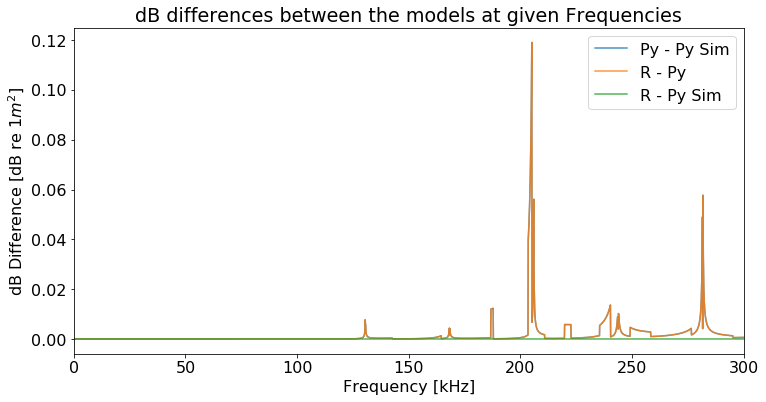

In [302]:
#Create TS difference plot
fig, ax = plt.subplots(figsize=(12,6))

TSdf.plot(kind='line',x='freqs',y='Py - Py Sim',ax=ax,alpha=0.8)
TSdf.plot(kind='line',x='freqs',y='R - Py',ax=ax,alpha=0.8)
TSdf.plot(kind='line',x='freqs',y='R - Py Sim',ax=ax,alpha=0.8)
plt.xlabel("Frequency [kHz]")
plt.ylabel("dB Difference [dB re 1$m^2$]")
plt.title("dB differences between the models at given Frequencies")
plt.show()

In [300]:

#barplot of time required for simulations
timedf = pd.DataFrame({ 'Time single':[tel_s0, tel_s1, tel_sR],
                       'Time Multi':[tel_0, tel_1, tel_R]},
                      index=['Python', 'Python Simple', 'R'])

round(timedf,4)

,Time single,Time Multi
Python,0.0011,2.6421
Python Simple,0.0007,2.1341
R,0.0030,3.1041


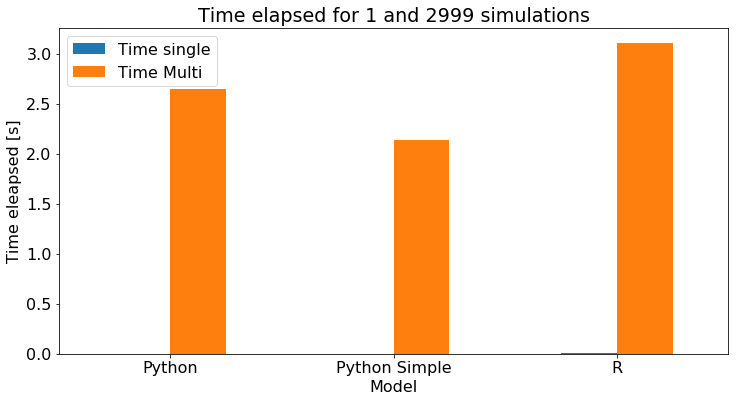

In [301]:
timedf.plot.bar(rot=0, figsize=(12,6))
plt.xlabel("Model")
plt.ylabel("Time eleapsed [s]")
plt.title("Time elapsed for 1 and %i simulations"%(len(TS_py)))
plt.show()
